In [1]:
import datetime as dt
import os
import sys
sys.path.append(os.pardir)

import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

from covid_19.compartmental_models import SEIRDModel

In [2]:
# total data
confirmed_cases = np.loadtxt('../data/confirmed_cases.dat')
recovered_cases = np.loadtxt('../data/recovered_cases.dat')
death_cases = np.loadtxt('../data/death_cases.dat')
removed_cases = recovered_cases + death_cases
active_cases = confirmed_cases - removed_cases

In [3]:
def plot_simulation(
    active_cases, 
    recovered_cases, 
    death_cases,
    I, 
    R,
    D,
    epidemics_start_date,
):
    """Plot the simulation.
    
    Parameters
    ----------
    active_cases : numpy.ndarray
        Time series of currently active infected individuals.  
    recovered_cases : numpy.ndarray
        Time series of deceased individuals.
    death_cases : numpy.ndarray
        Time series of deceased individuals.
    I : numpy.ndarray or list
        Fitted curve to the number of active cases.
    R : numpy.ndarray or list
        Fitted curve to the number of recovered cases.
    D : numpy.ndarray or list
        Fitted curve to the number of death cases.
    epidemics_start_date : datetime.datetime
        The first day of the epidemics outbreak.
    """
    duration = active_cases.size
    end = epidemics_start_date + dt.timedelta(days=duration)    
    days = mdates.drange(epidemics_start_date, end, dt.timedelta(days=1))
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    _ = fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    _ = fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))
    ax.plot(days, I, 'r-', label='$I(t)$')
    ax.plot(days, R, 'g-', label='$R(t)$')
    ax.plot(days, D, 'b-', label='$D(t)$')
    ax.plot(
        days,
        active_cases, 
        linestyle='None', 
        marker='o', 
        color='red', 
        alpha=0.7, 
        label='Active infections',
    )
    ax.plot(
        days,
        recovered_cases, 
        linestyle='None', 
        marker='o', 
        color='green', 
        alpha=0.7, 
        label='Recovered cases',
    )
    ax.plot(
        days,
        death_cases, 
        linestyle='None', 
        marker='o', 
        color='blue', 
        alpha=0.7, 
        label='Deceased cases',
    )
    _ = plt.gcf().autofmt_xdate()
    plt.ylabel('$N$')
    plt.legend(loc='best')
    plt.grid()
    plt.show()


def multiple_waves_sim(
    active_cases, 
    recovered_cases, 
    death_cases,
    first_wave_eff_population,
    eff_dates,
    plot_sim=False,
):
    """Simulate multiple epidemiological waves phenomena.
    
    Parameters
    ----------
    active_cases : numpy.ndarray
        Time series of currently active infected individuals.  
    recovered_cases : numpy.ndarray
        Time series of deceased individuals.
    death_cases : numpy.ndarray
        Time series of deceased individuals.
    first_wave_eff_population : int
        Number of effective susceptible population.
    eff_dates : list
        List of datetime.datetime formated effective dates 
        which mark the beginning of an increase in the number
        of infected individuals (first day of the new wave).
    plot_sim : bool
        Indicates if the simulation will be plotted.
    
    Returns
    -------
    tuple
        Tuple which contains values of the fitted S, E, I, R 
        and D curves.
    """
    eff_population_scaler = 1
    S0 = first_wave_eff_population * eff_population_scaler
    initial_conditions = [
        S0,
        3 * active_cases[0],
        active_cases[0],
        recovered_cases[0],
        death_cases[0]
    ]
    S_tot, E_tot, I_tot, R_tot, D_tot = [], [], [], [], []
    start_idx = 0
    # past wave(s) simulation
    for start_date, end_date in zip(eff_dates[:-1], eff_dates[1:]):
        end_idx = start_idx+abs((end_date - start_date).days)
    
        seird_model = SEIRDModel()
        (beta, alpha, gamma, mu), _ = seird_model.fit(
            active_cases[start_idx:end_idx], 
            recovered_cases[start_idx:end_idx], 
            death_cases[start_idx:end_idx], 
            initial_conditions=initial_conditions,
            loss_fn='mse',
        )
        (S, E, I, R, D) = seird_model.predict(end_idx - start_idx)
        S_tot.extend(S.tolist())
        E_tot.extend(E.tolist())
        I_tot.extend(I.tolist())
        R_tot.extend(R.tolist())
        D_tot.extend(D.tolist())
        
        # update initial conditions
        eff_population_scaler += 1
        S0 = S0 * eff_population_scaler
        initial_conditions = [
            S0,
            3 * I[-1],
            I[-1],
            R[-1],
            D[-1]
        ]
        # update indexing
        start_idx = end_idx
        
    # current wave simulation   
    seird_model = SEIRDModel()
    (beta, alpha, gamma, mu), loss = seird_model.fit(
        active_cases[start_idx:], 
        recovered_cases[start_idx:], 
        death_cases[start_idx:], 
        initial_conditions=initial_conditions,
        loss_fn='mse',
    )
    (S, E, I, R, D) = seird_model.predict(active_cases[start_idx:].size)
    S_tot.extend(S.tolist())
    E_tot.extend(E.tolist())
    I_tot.extend(I.tolist())
    R_tot.extend(R.tolist())
    D_tot.extend(D.tolist())
    
    if plot_sim:
        plot_simulation(
            active_cases, 
            recovered_cases, 
            death_cases, 
            I_tot,
            R_tot, 
            D_tot,
            eff_dates[0],
        )
    return (S_tot, E_tot, I_tot, R_tot, D_tot)

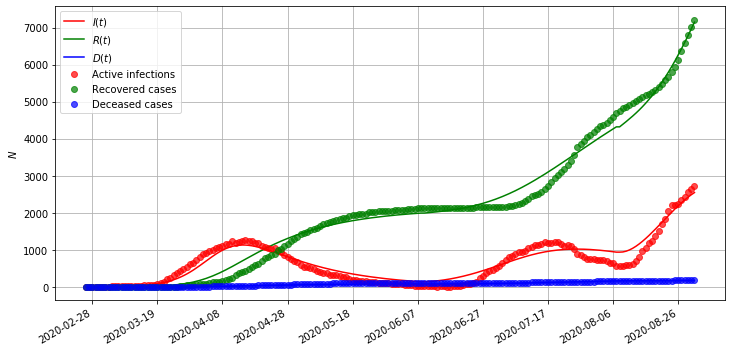

In [4]:
(S, E, I, R, D) = multiple_waves_sim(
    active_cases=active_cases, 
    recovered_cases=recovered_cases,
    death_cases=death_cases,
    first_wave_eff_population=2200,
    eff_dates=[
        dt.datetime(2020, 2, 26),
        dt.datetime(2020, 6, 9),
        dt.datetime(2020, 8, 8),
    ],
    plot_sim=True,
)